In [1]:
%matplotlib nbagg
import binascii
import logging

import matplotlib.pyplot as plt
import qcodes as qc
import numpy as np
import qcodes.instrument_drivers.tektronix.TPS2012 as tektps

from time import time

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
tps = tektps.TPS2012('TPS1', 'ASRL2::INSTR')

INFO:qcodes.instrument_drivers.tektronix.TPS2012:Set VISA encoding to latin-1
DEBUG:pyvisa:viWrite(1, b'DATa:ENCdg RPBinary\r\n', 21, 'c_uint(21)') -> 0
INFO:qcodes.instrument_drivers.tektronix.TPS2012:Set TPS2012 data encoding to RPBinary (Positive Integer Binary)
DEBUG:pyvisa:viWrite(1, b'DATa:WIDTh 2\r\n', 14, 'c_uint(14)') -> 0
INFO:qcodes.instrument_drivers.tektronix.TPS2012:Set TPS2012 data width to 2


Connected to: TEKTRONIX TPS 2012B (serial:0, firmware:CF:91.1CT FV:v11.10) in 1.92s


In [3]:
# For good measurems, one may clear out old messages
tps.clear_message_queue()

DEBUG:pyvisa:viGetAttribute(1, 1073676314, 'c_uint(20000)') -> 0
DEBUG:pyvisa:viSetAttribute(1, 1073676314, 1000) -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10b351730>, 20480, 'c_uint(0)') -> -1073807339
DEBUG:pyvisa:ASRL2::INSTR - exception while reading: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
DEBUG:pyvisa:viSetAttribute(1, 1073676314, 20000) -> 0


## SETTING UP AN ACQUISITION
The driver supports basic setting of scales and triggers.

In this example, we want to look at a 10 kHz sine, 100 mVpp with a -50 mV offset.

The sine is on channel **1**, while the sync (0 V to 3 V square wave) signal from the function generator is on channel **2**.

In [4]:
# horizontal
tps.horizontal_scale.set(10e-6)
# channel 1
tps.ch1_scale.set(50e-3)  # V/div
tps.ch1_position.set(2)  # divisions
# channel 2
tps.ch2_scale.set(1)
tps.ch2_position.set(-3)
# trigger
tps.trigger_type.set('EDGE')
tps.trigger_source.set('CH2')
tps.trigger_level.set(1.5)

DEBUG:pyvisa:viWrite(1, b'HORizontal:SCAle 1e-05\r\n', 24, 'c_uint(24)') -> 0
DEBUG:pyvisa:viWrite(1, b'CH1:SCAle 0.05\r\n', 16, 'c_uint(16)') -> 0
DEBUG:pyvisa:viWrite(1, b'CH1:POSition 2\r\n', 16, 'c_uint(16)') -> 0
DEBUG:pyvisa:viWrite(1, b'CH2:SCAle 1\r\n', 13, 'c_uint(13)') -> 0
DEBUG:pyvisa:viWrite(1, b'CH2:POSition -3\r\n', 17, 'c_uint(17)') -> 0
DEBUG:pyvisa:viWrite(1, b'TRIGger:MAIn:TYPe EDGE\r\n', 24, 'c_uint(24)') -> 0
DEBUG:pyvisa:viWrite(1, b'TRIGger:MAIn:EDGE:SOURce CH2\r\n', 30, 'c_uint(30)') -> 0
DEBUG:pyvisa:viWrite(1, b'TRIGger:MAIn:LEVel 1.5\r\n', 24, 'c_uint(24)') -> 0


## ACQUIRING THE CURVES FROM THE OSCILLOSCOPE
There is a simple command to get two arrays for the horizontal and vertical data.

Because this is early beta version you must currently call `set_set_points` on each channel before reading a trace from the channel 

In [5]:
tps.ch1_curvedata.set_set_points()
tps.ch2_curvedata.set_set_points()
data = qc.Measure(tps.ch1_curvedata, tps.ch2_curvedata).run()

DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10b351598>, 20480, 'c_uint(5156)') -> 0
DEBUG:pyvisa:viWrite(1, b'*WAI\r\n', 6, 'c_uint(6)') -> 0
DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10b351400>, 20480, 'c_uint(5156)') -> 0
DEBUG:pyvisa:viWrite(1, b'*WAI\r\n', 6, 'c_uint(6)') -> 0
DEBUG:pyvisa:viWrite(1, b'DATa:SOURce CH1\r\n', 17, 'c_uint(17)') -> 0
DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10b869ae8>, 20480, 'c_uint(5157)')

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-17/15-56-46'
   <Type>   | <array_id>               | <array.name>      | <array.shape>
   Measured | TPS1_scope_measurement_0 | scope_measurement | (2500,)
   Measured | TPS1_scope_measurement_1 | scope_measurement | (2500,)
acquired at 2017-01-17 15:57:00


<IPython.core.display.Javascript object>


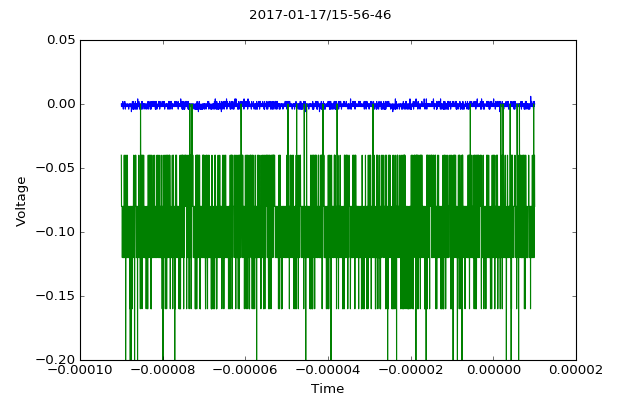

In [6]:
plot = qc.MatPlot()
plot.add(data.TPS1_scope_measurement_0)
plot.add(data.TPS1_scope_measurement_1)

Change horisontal scale and remember to call set_set_points to update the setpoint array

In [7]:
tps.horizontal_scale.set(1)

DEBUG:pyvisa:viWrite(1, b'HORizontal:SCAle 1\r\n', 20, 'c_uint(20)') -> 0


In [8]:
tps.ch1_curvedata.set_set_points()
tps.ch2_curvedata.set_set_points()
data2 = qc.Measure(tps.ch1_curvedata, tps.ch2_curvedata).run()

DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10b8e17b8>, 20480, 'c_uint(5154)') -> 0
DEBUG:pyvisa:viWrite(1, b'*WAI\r\n', 6, 'c_uint(6)') -> 0
DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10bbf2840>, 20480, 'c_uint(5154)') -> 0
DEBUG:pyvisa:viWrite(1, b'*WAI\r\n', 6, 'c_uint(6)') -> 0
DEBUG:pyvisa:viWrite(1, b'DATa:SOURce CH1\r\n', 17, 'c_uint(17)') -> 0
DEBUG:pyvisa:viWrite(1, b'WAVFrm?\r\n', 9, 'c_uint(9)') -> 0
DEBUG:pyvisa:ASRL2::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x10bbf2a60>, 20480, 'c_uint(5155)')

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-17/15-57-37'
   <Type>   | <array_id>               | <array.name>      | <array.shape>
   Measured | TPS1_scope_measurement_0 | scope_measurement | (2500,)
   Measured | TPS1_scope_measurement_1 | scope_measurement | (2500,)
acquired at 2017-01-17 15:57:51


<IPython.core.display.Javascript object>


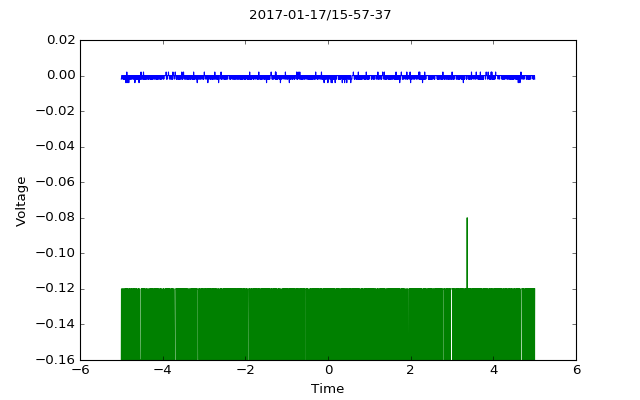

In [9]:
plot = qc.MatPlot()
plot.add(data2.TPS1_scope_measurement_0)
plot.add(data2.TPS1_scope_measurement_1)

In [13]:
tps.close()

DEBUG:pyvisa:ASRL2::INSTR - closing
DEBUG:pyvisa:viDisableEvent(1, 1073709055, 65535) -> 1073676291
DEBUG:pyvisa:viDiscardEvents(1, 1073709055, 65535) -> 1073676292
DEBUG:pyvisa:viClose(1,) -> 0
DEBUG:pyvisa:ASRL2::INSTR - is closed
DEBUG:pyvisa:ASRL2::INSTR - closing


In [ ]:
data.TPS1_scope_measurement_0.c